In [100]:
import numpy as np
import matplotlib.pyplot as plt
import obspy

import fbpicker.pickers as pick
import hodogram.hodogram as hd

In [101]:
import segyio
def creat_velocity_segy(vel, dir, dx = 10, dt = 10):
    seis = vel
    spec = segyio.spec()
    spec.samples = list(np.int32(np.arange(vel.shape[0])* dt))
    spec.format = 5
    spec.tracecount =vel.shape[1]
    with segyio.create(dir, spec) as f:
## fill the file with data
        for i in range(vel.shape[1]):
            t = i 
            f.trace[t] = seis[:,i]
            f.header[t][segyio.TraceField.FieldRecord] = 0
            f.header[t][segyio.TraceField.ShotPoint] = 0
            f.header[t][segyio.TraceField.TraceNumber] = i+1
            f.header[t][segyio.TraceField.ReceiverGroupElevation] = 10
            f.header[t][segyio.TraceField.GroupX] = i*dx
            f.header[t][segyio.TraceField.SourceX] = i*dx
            f.header[t][segyio.TraceField.TRACE_SAMPLE_INTERVAL] = 10
            
def read_segy(data_dir,shotnum=0):
    with segyio.open(data_dir,'r',ignore_geometry=True) as f:
        #f.mmap()
        sourceX = f.attributes(segyio.TraceField.SourceX)[:]
        shot_p = sourceX.copy()
        trace_num = len(sourceX)#number of trace, The sourceX under the same shot is the same character.
        if shotnum:
            shot_num = shotnum 
        else:
            shot_num = len(set(sourceX))#shot number 
        len_shot = trace_num//shot_num #The length of the data in each shot data
        time = f.trace[0].shape[0]
        '''
        The data of each shot is read separately
        The default is that the data dimensions collected by all shots in the file are the same.
        Jump=1, which means that the data of all shots in the file is read by default. 
        When jump=2, it means that every other shot reads data.
        '''
        print('start read segy data')
        data = np.zeros((shot_num,time,len_shot))
        for j in range(0,shot_num):
            data[j,:,:] = np.asarray([np.copy(x) for x in f.trace[j*len_shot:(j+1)*len_shot]]).T
        return data

In [102]:
R_path = '../layer3/layer3model_v3000-X_reverse.sgy'
R = read_segy(R_path,shotnum=1)
print(R.shape)

Z_path = '../layer3/layer3model_v3000-Z.sgy'
Z = read_segy(Z_path,shotnum=1)
print(Z.shape)


start read segy data
(1, 2001, 301)
start read segy data
(1, 2001, 301)


In [103]:
R = R[0,:,:]
Z = Z[0,:,:]

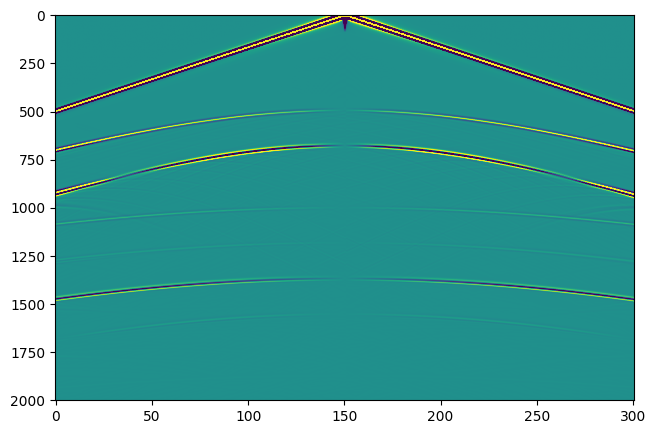

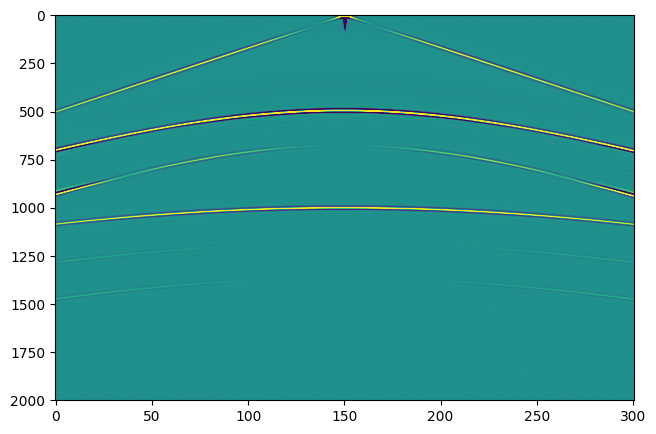

In [104]:
plt.figure(figsize=(10,5))
plt.imshow(R,aspect=0.1,vmin=-0.1,vmax=0.1)
plt.figure(figsize=(10,5))
plt.imshow(Z,aspect=0.1,vmin=-0.1,vmax=0.1)

In [105]:
def ratio_all(theta, window_length, Z, R):

    num_samples, num_traces = Z.shape

    current_R = np.zeros((num_samples, num_traces))
    current_Z = np.zeros((num_samples, num_traces))

    p = np.zeros((num_samples, num_traces))
    sv = np.zeros((num_samples, num_traces))
    ratio = np.zeros((num_samples, num_traces))
    
    # 滑动窗口处理
    for j in range(num_traces):  
        for i in range(num_samples):  
      
            start_idx = max(i - window_length // 2, 0)  
            end_idx = min(i + window_length // 2 + 1, num_samples)  
            
            # 计算当前时窗内的均值
            current_Z[i, j] = np.mean(Z[start_idx:end_idx, j])
            current_R[i, j] = np.mean(R[start_idx:end_idx, j])
            
            # 计算 p 和 sv
            p[i, j] = np.cos(theta) * current_Z[i, j] + np.sin(theta) * current_R[i, j]
            sv[i, j] = -np.sin(theta) * current_Z[i, j] + np.cos(theta) * current_R[i, j]
            
            # 计算 p 和 sv 的比值，避免除零错误
            if np.abs(sv[i, j]) != 0:
                ratio[i, j] = np.abs(p[i, j]) / np.abs(sv[i, j])
            else:
                ratio[i, j] = np.nan  

    return ratio


window_length = 30

# 初始化 ratio 数组
theta_values = np.linspace(-30, 30, 60)  
ratios = np.zeros((len(theta_values), Z.shape[0], Z.shape[1]))  

# 对每个 theta 计算相应的比值
for i, theta in enumerate(theta_values):
    ratios[i, :, :] = ratio_all(np.deg2rad(theta), window_length, Z, R)  

# 输出最终的比值矩阵
print("Average ratio of p to sv for each theta:")
print(ratios.shape)

Average ratio of p to sv for each theta:
(60, 2001, 301)


In [106]:
average_ratios = ratios.transpose(1, 0, 2)  # 转置，使得行对应时间步，列对应theta值
average_ratios = np.nan_to_num(average_ratios, nan=0)
print(average_ratios.shape)
print(average_ratios.min()) 
print(average_ratios.max()) 
print(average_ratios.mean())  

(2001, 60, 301)
0.0
76509379.13538615
10.832675755222057


In [107]:
log_average_ratios = np.log10(average_ratios)
log_average_ratios = np.nan_to_num(log_average_ratios,nan=0)
print(log_average_ratios.shape)
print(log_average_ratios.min())
print(log_average_ratios.max())
print(log_average_ratios.mean())

C:\Users\Cocklebur77\AppData\Local\Temp\ipykernel_21508\3025840761.py:1: RuntimeWarning: divide by zero encountered in log10
  log_average_ratios = np.log10(average_ratios)


(2001, 60, 301)
-1.7976931348623157e+308
7.883714677729613
-inf


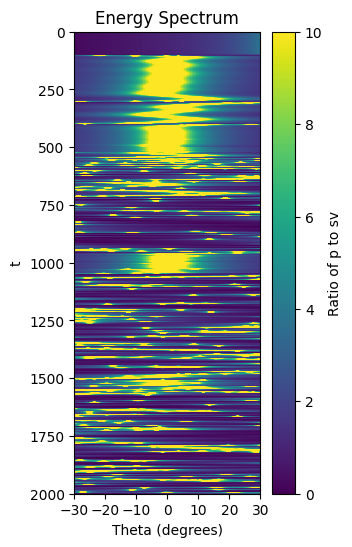

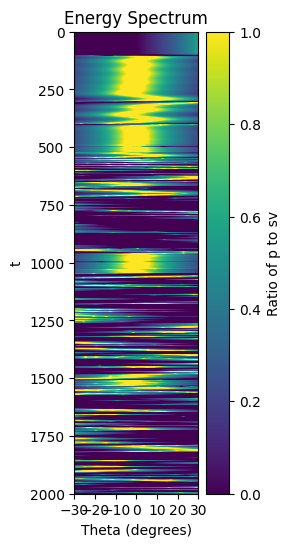

In [111]:
#average_ratios = ratios.transpose(1, 0, 2)  # 转置，使得行对应时间步，列对应theta值
#
look_trace = 150
# 绘制能量谱图
plt.figure(figsize=(3, 6))
plt.imshow(average_ratios[:,:,look_trace], aspect='auto', extent=[-30, 30, 0, 2000], 
           origin='lower', cmap='viridis',vmin=0,vmax=10) #
plt.colorbar(label='Ratio of p to sv')
plt.xlabel('Theta (degrees)')
plt.ylabel('t') #Window Center Position
plt.title('Energy Spectrum')
plt.xticks(np.arange(-30, 31, 10))
#plt.yticks(np.arange(0, window_num, 50)) 
plt.gca().invert_yaxis()
plt.show()


#---------plot log
plt.figure(figsize=(2, 6))
plt.imshow(log_average_ratios[:,:,look_trace], aspect='auto', extent=[-30, 30, 0, 2000], 
           origin='lower', cmap='viridis',vmin=0,vmax=1) #
plt.colorbar(label='Ratio of p to sv')
plt.xlabel('Theta (degrees)')
plt.ylabel('t') #Window Center Position
plt.title('Energy Spectrum')
plt.xticks(np.arange(-30, 31, 10))
#plt.yticks(np.arange(0, window_num, 50)) 
plt.gca().invert_yaxis()
plt.show()


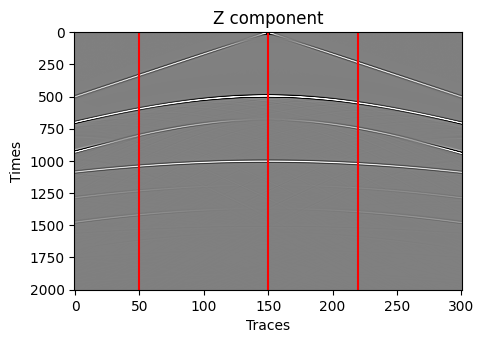

In [109]:
plt.figure(figsize=(5, 5))
plt.imshow(Z, aspect=0.1, vmin=-0.1, vmax=0.1, cmap='grey')

# remark trace 
columns = [50, 150, 220]
for col in columns:
    plt.axvline(x=col, color='red', linewidth=1.5)


#plt.colorbar(label="Value")
plt.title("Z component")
plt.xlabel("Traces")
plt.ylabel("Times")
plt.show()